# Columns LEGO

In [2]:
using LightGraphs, MetaGraphs
using Catlab, Catlab.WiringDiagrams, Catlab.Graphics

using PyCall # Needed for `PyGraphs` interop.
using CompositionalPlanning, CompositionalPlanning.PyGraphs

function visualize_plan(diagram::WiringDiagram; kw...)
    to_graphviz(diagram; label_attr=:xlabel, direction=:vertical, kw...)
end

cd("../data")

## Connectivity graph

Load the connectivity graph for the columns LEGO design.

In [3]:
connectivity_graph = read_connectivity_graph("columns.graphml")
graph = connectivity_graph.graph

{93, 106} directed simple Int64 graph

Display connectivity graph using Graphviz.

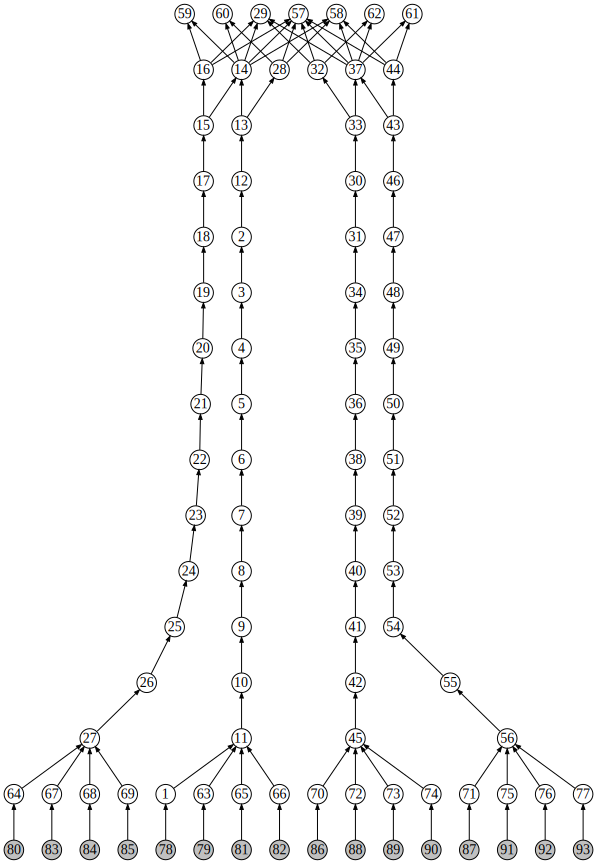

In [4]:
to_graphviz(connectivity_graph_to_dot(connectivity_graph))

## Planning

### Plan #1: Sequential plan

Create a sequential plan from the full connectivity graph.

In [5]:
plan1 = plan = sequential_plan(graph)
nboxes(plan)

92

In [6]:
write_graphml(plan, "columns_sequential_plan.graphml");

Visualize plan without drawing the labels or the incoming or outgoing wires.

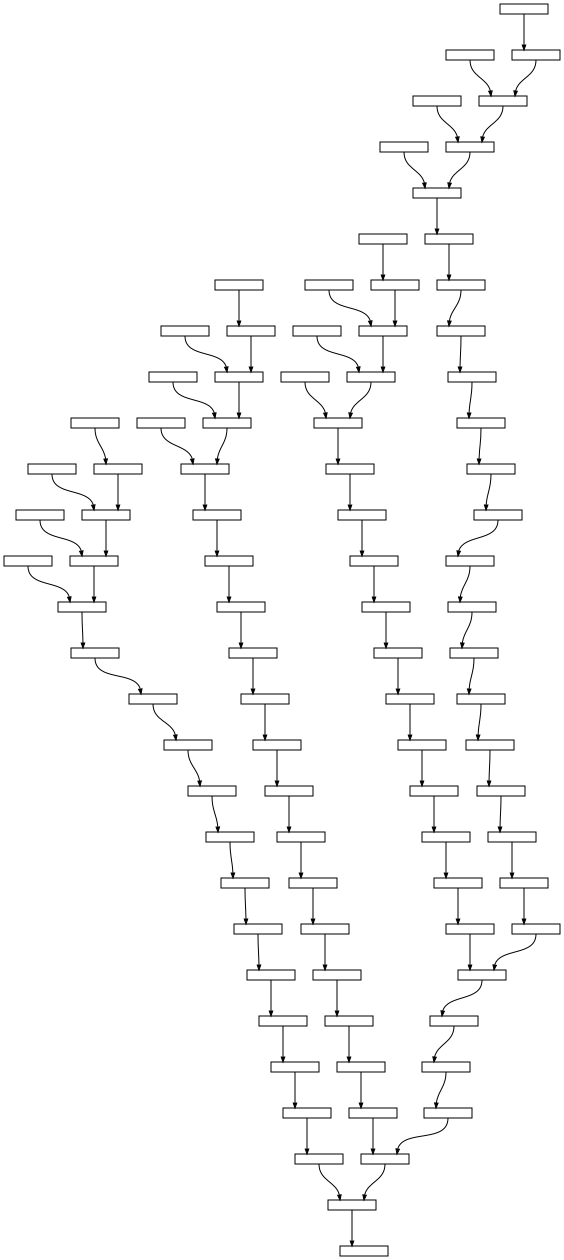

In [9]:
visualize_plan(plan, labels=false, outer_ports=false)

Visualize the plan with all information attached. This one is big, so we export it for viewing outside the notebook.

In [10]:
graphviz = visualize_plan(plan, labels=true)
open("columns_sequential_plan.svg", "w") do io
   show(io, MIME("image/svg+xml"), graphviz)
end

### Plan #2: Parallel plan using Girvan-Newman algorithm

Identify the four columns and the roof using the [Girvan-Newman algorithm](https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm) for community detection. We cheat a little by hardcoding the number of components.

In [12]:
components = last(PyGraphs.nx_girvan_newman(Graph(graph), 4))
components = [ sort(collect(c)) for c in components ]
components

5-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 63, 65, 66, 78, 79, 81, 82]         
 [13, 14, 15, 16, 28, 29, 32, 33, 37, 43, 44, 46, 57, 58, 59, 60, 61, 62]    
 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 64, 67, 68, 69, 80, 83, 84, 85]
 [30, 31, 34, 35, 36, 38, 39, 40, 41, 42, 45, 70, 72, 73, 74, 86, 88, 89, 90]
 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 71, 75, 76, 77, 87, 91, 92, 93]    

Build a parallel plan on these five components.

In [13]:
plan2 = plan = parallel_plan(graph, components)
nboxes(plan)

9

In [14]:
write_graphml(plan, "columns_parallel_plan.graphml");

At the top level, the five components are black boxes, connected in sequence. (The visualization is easier to read if we do not draw the ports and wires of outer box.)

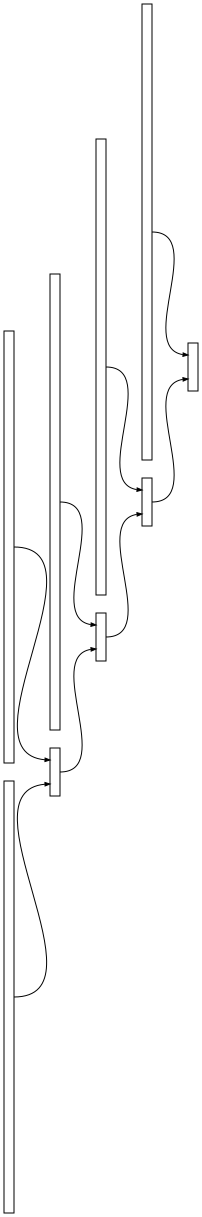

In [16]:
visualize_plan(plan, labels=false, outer_ports=false, direction=:horizontal)

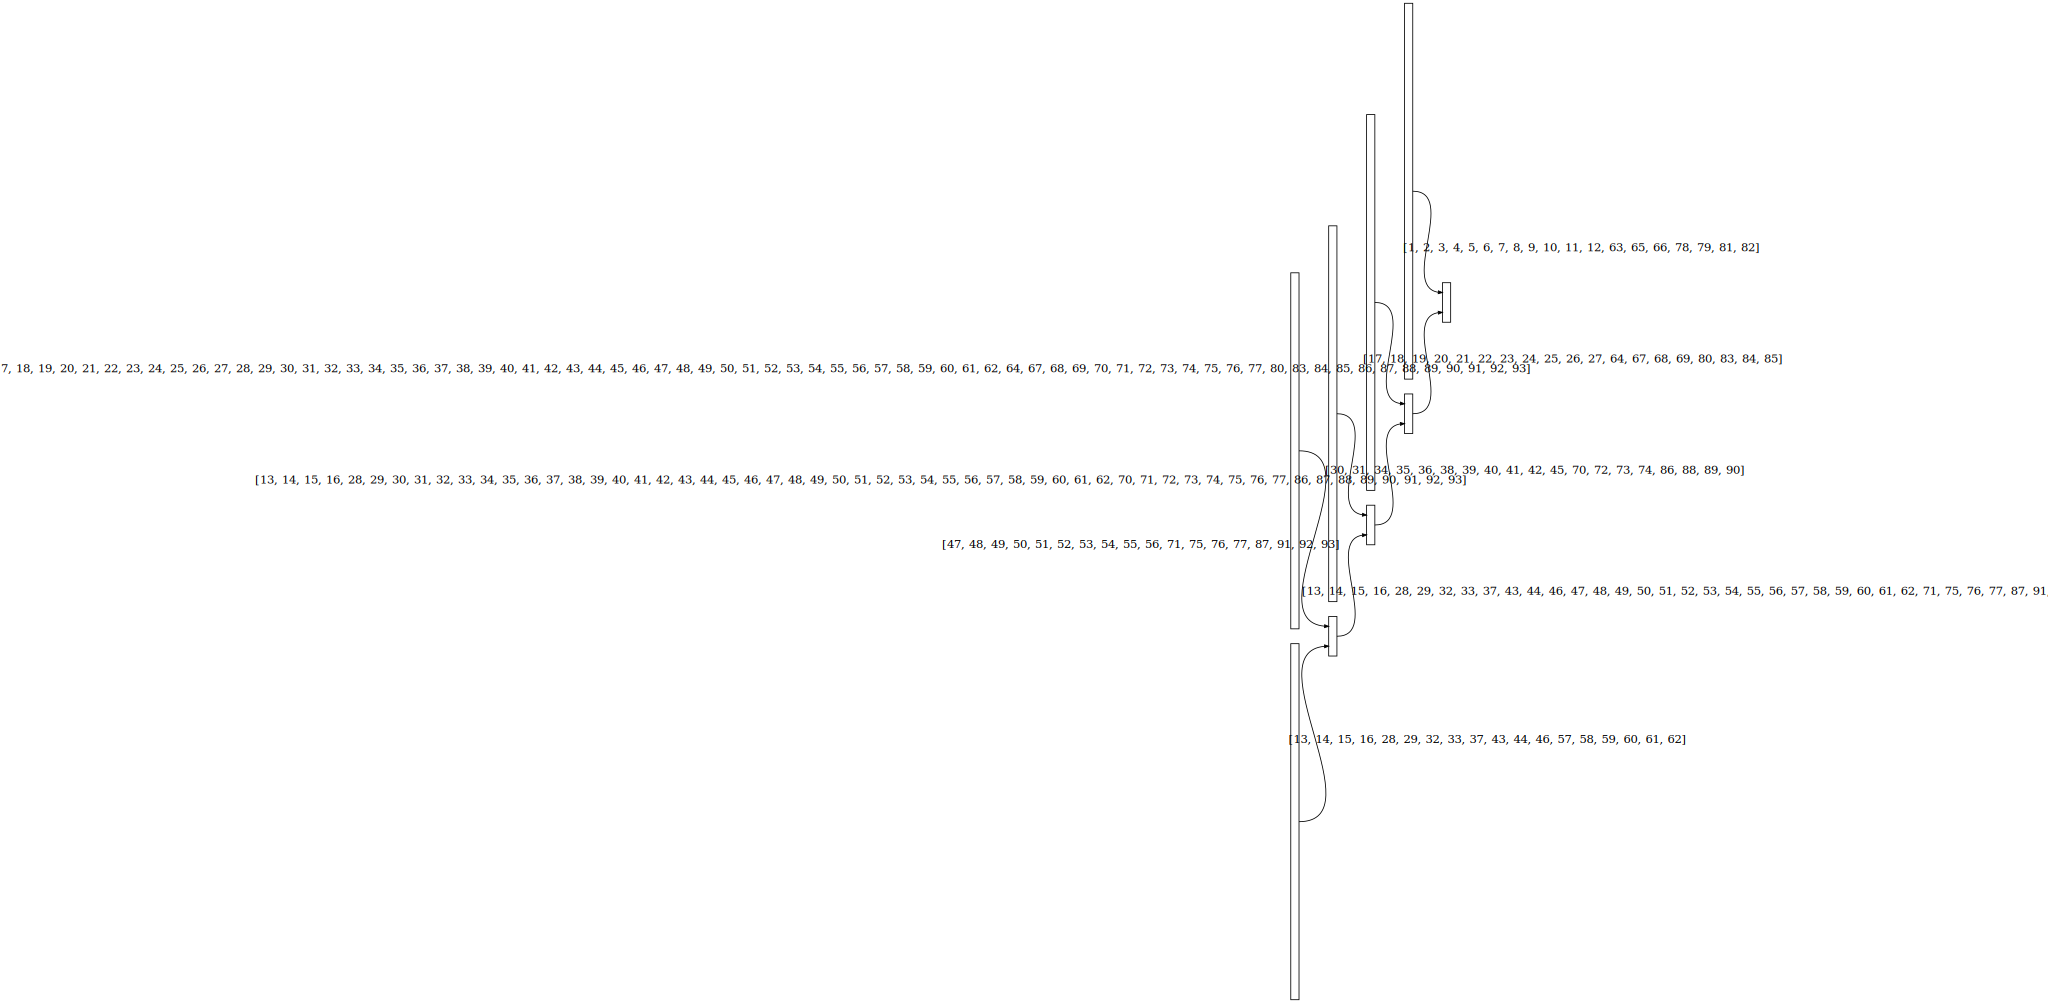

In [17]:
visualize_plan(plan, labels=true, outer_ports=false, direction=:horizontal)

To verify this, inspect the types of the boxes:

In [18]:
map(typeof, boxes(plan))

9-element Array{DataType,1}:
 WiringDiagram
 WiringDiagram
 WiringDiagram
 WiringDiagram
 WiringDiagram
 Box{Nothing} 
 Box{Nothing} 
 Box{Nothing} 
 Box{Nothing} 

Here is a sub-plan for one of the columns.

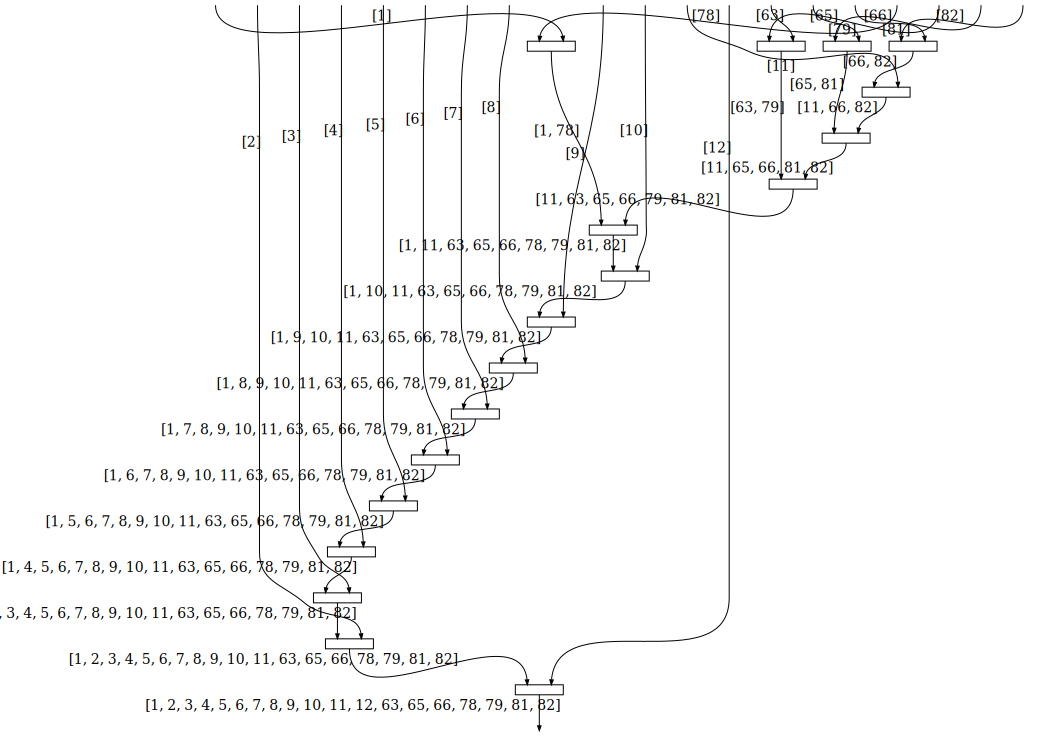

In [19]:
column_plan = first(boxes(plan))
visualize_plan(column_plan, labels=true)

Expand all the sub-plans and generate one big plan.

In [20]:
subplans = filter(v -> box(plan,v) isa WiringDiagram, box_ids(plan))
substitute!(plan, subplans)

nboxes(plan)

92

## Scheduling

Convert the two plans into expressions and then into schedules.

In [21]:
steps1, steps2 = map((plan1, plan2)) do plan
    plan_expr = to_hom_expr(PlanningExpr, plan)
    steps = jsonable_schedule(interleave_hom_expr(plan_expr))
end;

For the first schedule, show the *smaller* piece of each join operation.

In [22]:
map(steps1) do (operator, inputs, outputs)
    in1, in2 = inputs
    if length(in2) >= length(in1); in1, in2 = in2, in1 end
    in2
end

92-element Array{Array{Int64,1},1}:
 [78]                                                                               
 [85]                                                                               
 [82]                                                                               
 [90]                                                                               
 [79]                                                                               
 [80]                                                                               
 [81]                                                                               
 [87]                                                                               
 [11]                                                                               
 [83]                                                                               
 [65, 81]                                                                           
 [86]                        

Export the schedules as JSON.

In [17]:
import JSON

open("columns_sequential_schedule.json", "w") do io
   JSON.print(io, steps1)
end
open("columns_parallel_schedule.json", "w") do io
   JSON.print(io, steps2)
end